https://github.com/abhinavsagar/cryptocurrency-price-prediction/blob/master/price_prediction_update.ipynb
pull data - LSTM

In [7]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

UsageError: Line magic function `%tensorflow_version` not found.


In [9]:
import requests
import pandas as pd
import json

endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'


In [3]:
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [11]:
hist.head(5)
hist.tail(4)

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2023-06-04,36777.18,36243.36,36341.22,36.57,1330853.36,36328.16,direct,
2023-06-05,36345.62,34230.10,36328.16,78.11,2749580.77,34604.35,direct,
2023-06-06,36564.69,34151.79,34604.35,75.10,2635321.30,36476.25,direct,
2023-06-07,36612.52,35054.25,36476.25,57.41,2045347.64,35466.19,direct,


In [28]:
res = requests.get(endpoint + '?fsym=BTC&tsyms=CAD')
latest_price = json.loads(res.content)['CAD']
print('Latest BTC/CAD price:', latest_price)


KeyError: 'CAD'

In [ ]:
hist.head(5)
hist.tail(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2023-06-03,36722.29,36170.47,36629.36,38.82,1415445.43,36341.22
2023-06-04,36777.18,36243.36,36341.22,36.57,1330853.36,36328.16
2023-06-05,36345.62,34230.10,36328.16,78.11,2749580.77,34604.35
2023-06-06,36564.69,34151.79,34604.35,75.10,2635321.30,36476.25
2023-06-07,36612.52,35054.25,36476.25,57.04,2032009.26,35320.91


In [ ]:
import requests
import pandas as pd
import json

endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'


In [ ]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [ ]:
train, test = train_test_split(hist, test_size=0.2)

In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [ ]:
import matplotlib.pyplot as plt

line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [ ]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [ ]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
import numpy as np

np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [22]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.layers import Activation

model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

13/13 [==============================] - 12s 181ms/step - loss: 0.0064 - val_loss: 0.0031
Epoch 2/20
13/13 [==============================] - 0s 25ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 3/20
13/13 [==============================] - 0s 21ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 4/20
13/13 [==============================] - 0s 26ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 5/20
13/13 [==============================] - 0s 19ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 6/20
13/13 [==============================] - 0s 19ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 7/20
13/13 [==============================] - 0s 19ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 8/20
13/13 [==============================] - 0s 20ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 9/20
13/13 [==============================] - 0s 29ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 10/20
13/13 [==============================] - 0s 19ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 11/20
13/13 

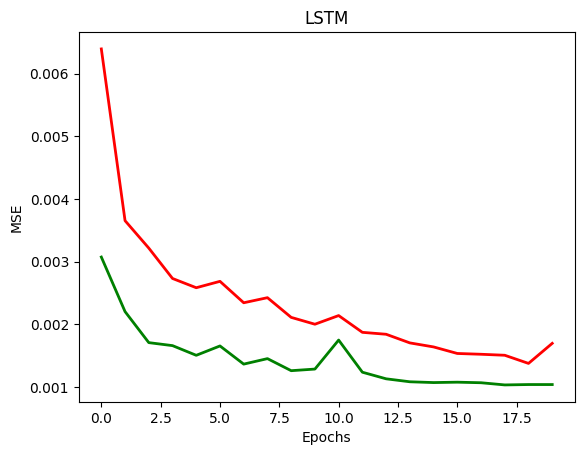

In [23]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

In [ ]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE


In [ ]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)